<h1> Get Time corpus </h1>

See the README.md file for background to the following steps. 



In [1]:
#imports
import pandas as pd
import pickle
import numpy as np
from collections import Counter, OrderedDict
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

<h4> Data after Pre-Processing 1 and 2 </h4>

Formats: 
- df = Dataframe with information about title, substance, class, url, text of each report
- corpus_list = List of all the report texts concatenated 

In [2]:
df = pd.read_pickle("clean_processed_data.pkl")


corpus_list = []
for text in df.text:
    corpus_list += text

<h4> Seed time perception words </h4>

- These words act as 'seeds' in the Erowid Corpus. Words surrounding the seed might describe information about time perception. 

- This list of words was generated by entering words such as 'time', 'faster', 'slower' in websites such as https://relatedwords.io/ or online synonom finders, and subjectively selecting appropriate ones. 

- Seed words consist of neutral time perception (ntp), fast time perception (ftp), and slow time perception (stp) words. Ftp and stp words were balanced (next step).

In [3]:
ntp_words = ['time', 'period', 'periods', 'duration', 'clock', 'temporal', 'spacetime', 'timespan', 'timespans', 'timeline', 'timelines', 'elapse', 'elapsed', 'length', 'speed', 'timewise', 'velocity', 'pace', 'rate', 'tempo', 'passing', 'passed']
ftp_words = ['quick','quicker', 'quickly', 'quickest', 'fast', 'faster', 'fastest', 'fastened', 'rapid','rapidly', 'short', 'shorter', 'shortly', 'shortest','speedy', 'speedy','speeded', 'speedier', 'hurry', 'hurried', 'swift', 'swifter', 'swiftly', 'haste', 'hasty', 'brisk', 'turbo', 'acceleration', 'accelerated', 'accelerating']
stp_words = ['slow', 'slower', 'slowly', 'slows', 'slowed', 'slowest', 'slowdown', 'long', 'looong', 'longer', 'longer', 'longest', 'gradual', 'steady', 'deceleration', 'decelerate', 'decelerating', 'decelerated', 'unhurried', 'dilatory', 'infinity', 'eternity', 'lengthy', 'prolonged', 'protracted', 'extended', 'uneding', 'endless']
time_words = sorted(ntp_words + ftp_words + stp_words)


<h4> Balancing fast-slow seed words </h4>

- Ftp-stp words were 'balanced' by considering their relative frequency in the common English language. The SUBTLEX-UK is a 201.3 million words corpus generated from subtitles in BBC broadcasts. 

- The code below gets the frequencies of all ftp-stp words in SUBTLEX-UK. After adjusting ftp-stp words, there were ~19,000 occurences of each in the SUBTLEX-UK corpus.

- Df3 compares the relative frequencies of specific time words in both corpora


<h6> van Heuven, W.J.B., Mandera, P., Keuleers, E. and Brysbaert, M., 2014. Subtlex-UK: A New and Improved Word Frequency Database for British English. Quarterly Journal of Experimental Psychology [Online], 67(6), pp.1176–1190. Available from: https://doi.org/10.1080/17470218.2013.850521. </h6>

In [ ]:
#SUBTLEX-UK corpus
df3 = pd.read_excel("SUBTLEX-UK.xlsx")

#remove words from SUBTLEX not in time words
non_time_words = df3.Spelling.to_list()
for item in non_time_words:
    if item in time_words:
         non_time_words.remove(item)
df3 = df3[~df3.filter(items=['Spelling']).isin(non_time_words).any(1)] 

#formatting
df3.rename(columns = {'FreqCount':'SUBTLEX_freq', 'Spelling':"name"}, inplace = True)
df3.drop(df3.columns.difference(['name', 'SUBTLEX_freq']), 1, inplace=True)
df3.reset_index(inplace=True, drop=True)

#frequency of ftp-stp words in SUBTLEX 
df_fast = df3[~df3.filter(items=['name']).isin(ntp_words + stp_words).any(1)] 
df_fast.sort_values(by=["SUBTLEX_freq"], ascending=False, inplace=True)
print("SUBTLEX-UK FTP sum is")
print(df_fast["SUBTLEX_freq"].sum())

df_slow = df3[~df3.filter(items=['name']).isin(ntp_words + ftp_words).any(1)] 
df_slow.sort_values(by=["SUBTLEX_freq"], ascending=False, inplace=True)
print("SUBTLEX-UK STP sum is")
print(df_slow["SUBTLEX_freq"].sum())


#relative word frequency (=Erowid/SUBTLEX) dataframe

df3["Erowid_freq"] = 0
df3["Relative_freq"] = 0

for i, name in enumerate(df3.name):
    df3.loc[i, "Erowid_freq"] = corpus_list.count(name)
    df3.loc[i, "Relative_freq"] = corpus_list.count(name)/df3.loc[i, "SUBTLEX_freq"]

df3 = df3.sort_values(by='Relative_freq', ascending=False)


<h4> Get context window function </h4>

- Used to iterate through a list and yield C words before and after each seed word.

In [4]:
# Get context window function for time_words
def get_windows(words, C):
    i = C
    while i < len(words) - C:
        center_word = words[i]
        if center_word not in time_words:
            i += 1
            pass
        else:
            context_words = words[(i - C):i] + words[(i+1):(i+C+1)]
            yield context_words, center_word
            i += 1

<h4> Context window examples </h4>

- Get context window and report url for specific time seed words. 

- Line 7 can be adjusted to get the context windows for specific seed or context words. Very useful for understanding nodes in the co-occurence network graph (later).

In [7]:
#co-occurences in context window examples

def context_words_edges_vertices(C):
    for i, text in enumerate(df.text):
        url = df.loc[i, "url"]
        for context_words, center_word in get_windows(text, C):
            #can look for specific words
            if "shorter" == center_word: # line 7
                print(context_words[0:C])
                print(center_word)
                print(context_words[C:])
                print(url)
                print("\n")

context_words_edges_vertices(C=4)

<h4> Get all co-occurences in Time corpus  </h4>

- Time corpus = All context windows seeded by all time words.

- Get all pairs of word-occurence in each context window in the Time corpus. 

- Pairs stored in dataframe (df2) in the following format:


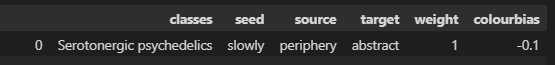


- The colourbias quantifies whether the seed word is a ntp, ftp, or stp. This score is used for visulization later. 

In [ ]:
%%time
#co-occurence network - edges

df2  = pd.DataFrame(columns = ["classes", "seed", "source", "target", "weight", "colourbias"])

def context_words_edges_vertices(C):
    for i, text in enumerate(df.text):
        print(i)
        classes = df.loc[i, "classes"]
        for context_words, center_word in get_windows(text, C):
            if center_word in ntp_words:
                all_pairs = [(a, b) for idx, a in enumerate(context_words) for b in context_words[idx + 1:]]
                for a, b in all_pairs:
                    df2.loc[len(df2.index)] = [classes, center_word, a, b, 1, 0]   
            elif center_word in ftp_words:
                all_pairs = [(a, b) for idx, a in enumerate(context_words) for b in context_words[idx + 1:]]
                for a, b in all_pairs:
                    df2.loc[len(df2.index)] = [classes, center_word, a, b, 1, 1]
            elif center_word in stp_words:
                all_pairs = [(a, b) for idx, a in enumerate(context_words) for b in context_words[idx + 1:]]
                for a, b in all_pairs:
                    df2.loc[len(df2.index)] = [classes, center_word, a, b, 1, -1]    

context_words_edges_vertices(C=4)


<h4> Relative Frequency </h4>

Calculates relative frequency (RF) of each word in time corpus. Similar to tf-idf (https://en.wikipedia.org/wiki/Tf%E2%80%93idf). Visualized with wordcloud. 

$$ RF = Freq_{Time corpus} / Freq_{Erowid corpus} $$


In [ ]:
#Time corpus as list
df2 = pd.read_pickle("timecorpus.pkl")
time_corpus_list = [source for source in df2.source]
    
for target in df2.target:
    time_corpus_list.append(target)


#Erowid corpus frequency dict
counter = Counter(corpus_list)
corpus_dict = dict(Counter({k: c for k, c in counter.items() if c > 10})) #can delete  c > 10 later when redoing pre-processing 2

#time corpus frequency dict
counter = Counter(time_corpus_list)
time_corpus_dict = dict(Counter({k: c for k, c in counter.items()}))

#relative frequency dict
relative_frequency_dict = {}
for item1 in time_corpus_dict.keys(): 
    for item2 in corpus_dict.keys():
        if item1 == item2:
            relative_frequency_dict[item1] = time_corpus_dict.get(item1)/corpus_dict.get(item2)      


#Wordcloud             
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate_from_frequencies(relative_frequency_dict)
                  
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title("Time Corpus Relative Frequency Wordcloud")         


<h4> Save file </h3>

In [ ]:

store_df = df2.copy(deep=True)
df2 = store_df.copy(deep=True)
df2.to_pickle("timecorpus.pkl")